# Quark / Gluon discrimination Pipeline
### Done in Python 2 for preprocessing

This is a quark-gluon binary classification pipeline. It constitutes


In [1]:
%%bash
#jupyter nbextension enable --py widgetsnbextension

In [2]:
import ROOT, sklearn
import flat_helper # includes numpy, and pandas
import numpy
# from keras_tqdm import TQDMNotebookCallback # uncomment this to get the progress bar
#import theano
#theano.config.gcc.cxxflags = '-march=corei7' 

Welcome to JupyROOT 6.08/06


/usr/local/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.12.0. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


# Loading data
We take advantage of the full quark and gluon standard datasets. An additional file, MAndrews_v1_CreateJetShapes.C, should be used to replace

In [3]:
# Load training data
dfQuarks = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/quarks_standard', -1, recompute=False)
dfGluons = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/gluons_standard', -1, recompute=False)
print "quarks_standard input shape:",dfQuarks.shape
print "gluons_standard input shape:",dfGluons.shape

Input dir: quarks_standard
nentries == 0? Please check path quarks_standard

Input dir: gluons_standard
nentries == 0? Please check path gluons_standard

quarks_standard input shape: (0, 4)
gluons_standard input shape: (0, 4)


Error in <TFile::TFile>: file quarks_standard_shapes.root does not exist
Error in <TFile::TFile>: file gluons_standard_shapes.root does not exist


# Feature Engineering
Further performance gains from the dataset can be had by concocting new features, some physically sensible, others less so. In particular we introduce the ff. new features through a modified version of CreateJetShapes.C:   
 - **trkPtSum:** scalar sum of all the track pTs
 - **towESum:** scalar sum of all the tower energies
 - **towEemSum:** scalar sum of all the EM tower energies
 - **towEhadSum:** scalar sum of all the Hadronic tower energies
 - **ntracks**   

For the above 5 along with **ntowers**, we form an additional 12 by taking their products and ratios with the jetPt. In addition, we throw in a few more ratios of the above quantities: **towEemoEhad, towEhadoEem, ntrkontow, ntowontrk**

In [5]:
# set labels
dfQuarks['isGluon'] = 0
dfGluons['isGluon'] = 1

We see that some of the newly engineered features do carry some discriminating power

/cvmfs/sft.cern.ch/lcg/releases/matplotlib/1.5.1-763af/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


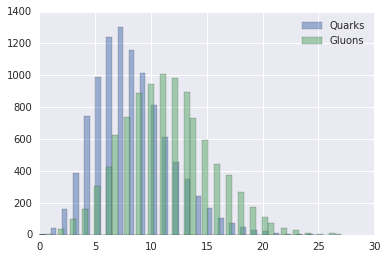

In [6]:
# some basic plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # cosmetics
%matplotlib inline
plt.hist(dfQuarks.ntrks[:10000], bins=50, alpha=0.5, label='Quarks')
plt.hist(dfGluons.ntrks[:10000], bins=50, alpha=0.5, label='Gluons')
plt.legend()

In [7]:
import pandas as pd
labels = pd.concat([dfQuarks['isGluon'],dfGluons['isGluon']])
trainData = pd.concat([dfQuarks.drop('isGluon',axis=1), dfGluons.drop('isGluon',axis=1)])
trainData.head()

,mass,ntowers,radial,dispersion,trkPt2JetPt,towE2JetPt,towEem2JetPt,towEhad2JetPt,ntow2JetPt,ntrk2JetPt,...,towESum,towEemSum,towEhadSum,trkPtSum,towEemoEhad,towEhadoEem,jetPt,ntrks,ntrkontow,ntowontrk
0,12.185929,11.0,0.045043,0.384206,7429.207520,4974.869141,4414.427246,560.442322,1140.531372,1036.846680,...,47.980759,42.575504,5.405257,71.651939,7.876684,0.126957,103.684669,10.0,0.0,1.0
1,5.329337,13.0,0.016920,0.436819,6781.064453,19437.882812,19437.882812,0.000000,1370.975952,632.758118,...,184.315765,184.315765,0.000000,64.300064,7.876684,0.000000,105.459686,6.0,0.0,2.0
2,6.688938,3.0,0.026399,0.509502,10261.902344,14502.754883,706.481323,13796.273438,353.077759,941.540649,...,123.225739,6.002769,117.222969,87.192429,0.051208,19.528151,117.692581,8.0,2.0,0.0
3,8.983985,11.0,0.027306,0.405769,5399.941406,13603.516602,4460.834473,9142.682617,1304.698364,1067.480469,...,114.692169,37.609596,77.082573,45.527271,0.487913,2.049545,118.608940,9.0,0.0,1.0
4,24.100706,12.0,0.111171,0.362364,6839.576660,6004.960938,2102.208252,3902.752686,1349.633179,1237.163696,...,53.391941,18.691376,34.700565,60.812763,0.538648,1.856501,112.469429,11.0,0.0,1.0


# Preprocessing
Learning progresses much faster if the input values are centered at zero with unit variance. Moreover, because of the vastly different scales in the inputs, learning does not progress at all unless we do so.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trainData[trainData.columns] = scaler.fit_transform(trainData[trainData.columns])
trainData.head()

,mass,ntowers,radial,dispersion,trkPt2JetPt,towE2JetPt,towEem2JetPt,towEhad2JetPt,ntow2JetPt,ntrk2JetPt,...,towESum,towEemSum,towEhadSum,trkPtSum,towEemoEhad,towEhadoEem,jetPt,ntrks,ntrkontow,ntowontrk
0,0.233205,0.248952,0.106707,-0.887742,0.003649,-0.509044,-0.359348,-0.456238,0.074515,0.051295,...,-0.490644,-0.333322,-0.454620,0.241489,-0.00051,-0.151854,-0.981516,0.251181,-0.673245,0.20510
1,-1.259204,0.653329,-0.936258,-0.515074,-0.221029,0.299590,0.813650,-0.513031,0.476818,-0.829380,...,0.376431,0.925228,-0.516663,-0.065691,-0.00051,-0.160984,-0.771601,-0.769007,-0.673245,1.23703
2,-0.963273,-1.368560,-0.584735,-0.000257,0.985600,0.023665,-0.648856,0.885039,-1.300196,-0.156416,...,-0.012095,-0.658062,0.828846,0.890809,-0.00051,1.243385,0.675070,-0.258913,1.230223,-0.82683
3,-0.463732,0.248952,-0.551105,-0.735009,-0.699795,-0.026612,-0.355724,0.413459,0.361113,0.118059,...,-0.066367,-0.377416,0.368106,-0.850065,-0.00051,-0.013591,0.783439,-0.003866,-0.673245,0.20510
4,2.826580,0.451141,2.559090,-1.042448,-0.200746,-0.451451,-0.539880,-0.117539,0.439559,0.487868,...,-0.456229,-0.545396,-0.118363,-0.211399,-0.00051,-0.027473,0.057376,0.506228,-0.673245,0.20510


Finally, split the data to training and cross-validation sets. When using the full dataset, it should be sufficient to use 100k events for CV and save the rest for training.

In [9]:
from sklearn.cross_validation import train_test_split

rawXtrain, rawXcv, ytrain, ycv = train_test_split(trainData, labels, random_state=1, test_size=100000)

# For Keras: recast as matrix
Xtrain = rawXtrain.as_matrix()
Xcv = rawXcv.as_matrix()
print "Input shape to model:",Xtrain.shape

Input shape to model: (7586910, 26)


# Defining the model
We use a 3-hidden layer fully-connected network: input->FC:64->FC:32->FC:1->output. Deeper and shallower networks were attempted but the below 3-layer network proved to work best. Other particulars:  
 - Sigmoid activation peformed better than the popular relu   
 - Unnecessary to apply L2 regularization   
 - Truncated Normal weight initializations work best   
 - Applied dropout


In [10]:
# Import some keras deps
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.initializations import glorot_normal

# Compile simple Keras model: fully-connected, multi-layer
model = Sequential()
model.add(Dense(64, activation='sigmoid', input_shape=(Xtrain.shape[1],), init='glorot_normal'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='sigmoid', init='glorot_normal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', init='glorot_normal'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

WARNING (theano.gof.cmodule): WARNING: your Theano flags `gcc.cxxflags` specify an `-march=X` flags.
         It is better to let Theano/g++ find it automatically, but we don't do it now


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 64)            1728        dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 64)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 32)            2080        dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 32)            0           dense_2[0][0]                    
___________________________________________________________________________________________

         It is better to let Theano/g++ find it automatically, but we don't do it now


# Running the model
We implement a few other best practices when training:   
 - learning rate decay every 8 epochs   
 - stop training if validation loss doesnt improve after 8 epochs   
 - Batch size of 64 performed better than larger batches
 
For this notebook, we load the trained model but the parameters of the fit are as commented.

In [11]:
'''
import math
import numpy as np
import keras.backend
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

numEpochs = 100
batchSize = 64
initial_lr = 0.005

# Implement step-wise LR decay
# NOTE: Scheduler called at beginning of epoch
def step_decay(epoch):
    lr0 = initial_lr
    decay_rate = 0.5
    epochs_period = 8
    #lr_final = 1.e-6
    lr = lr0 * math.pow(decay_rate, math.floor((1+epoch)/epochs_period))
    #if lr < lr_final:
    #    lr = lr_final
    print "lr:",lr
    #print "lr was:",keras.backend.get_value(model.optimizer.lr)    
    return lr

# Callbacks for LR decay, checkpoint creation, and early stopping, resp.:
lrate = LearningRateScheduler(step_decay)
ckpt = ModelCheckpoint('NN_model_{epoch:02d}-{val_loss:.4f}.h5',save_best_only=True)
earlystop = EarlyStopping(patience=6)

print "Fitting model"
hist = model.fit(Xtrain, ytrain, nb_epoch=numEpochs, batch_size=batchSize,
            validation_data=(Xcv, ycv), verbose=1, callbacks=[lrate,ckpt,earlystop])
model.save('MAndrews_v1_model.h5')
'''

# Load the trained model
del model  # deletes the existing model
from keras.models import load_model
model = load_model('MAndrews_v1_model.h5')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 64)            1728        dense_input_2[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 64)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 32)            2080        dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 32)            0           dense_2[0][0]                    
___________________________________________________________________________________________

# Evaluating on CV
Below we present standard metrics for evaluating the trained model on the CV set.

Confusion matrix

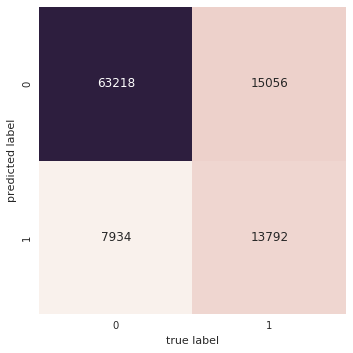

In [12]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

testPrediction = model.predict_classes(Xcv, verbose=0)
testPrediction = testPrediction.flatten()

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ycv, testPrediction)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
#                xticklabels=testLabels, yticklabels=testLabels)
plt.xlabel('true label')
plt.ylabel('predicted label');

And a quick look at the mis-ID'd jets looking at the mass

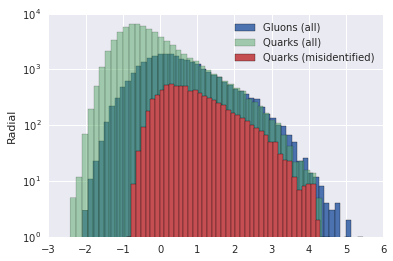

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

variableToPlot='mass'
plt.hist(rawXcv[ycv == 1][variableToPlot], bins=50, alpha=1, label='Gluons (all)');
plt.hist(rawXcv[ycv == 0][variableToPlot], bins=50, alpha=0.5, label='Quarks (all)');
plt.hist(rawXcv[(testPrediction != ycv) & (ycv == 0)][variableToPlot], bins=50, alpha=1, label='Quarks (misidentified)');
plt.gca().set_yscale("log")
plt.ylabel('Radial')
plt.legend();

And the ROC curve

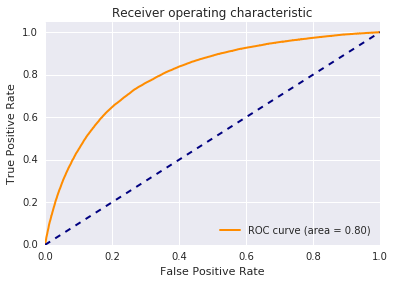

CV ROC AUC: 0.799327827597


In [14]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC AUC
y_score = model.predict_proba(Xcv, verbose=0)
fpr, tpr, thresholds = roc_curve(ycv,y_score[:,0])
roc_auc = auc(fpr,tpr) 
print "CV ROC AUC:",roc_auc

# Plot ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Testing on modified dataset
in the following cells, we use the model on the modified datasets

In [15]:
dfQuarksMod = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/quarks_modified', -1, recompute=False)
dfGluonsMod = flat_helper.GetJetShapesFast('/eos/project/i/iml/IMLChallengeQG/gluons_modified', -1, recompute=False)

Loading from root file _eos_project_i_iml_IMLChallengeQG_quarks_modified_shapes.root
Loading from root file _eos_project_i_iml_IMLChallengeQG_gluons_modified_shapes.root


In [16]:
dfQuarksMod['isGluon'] = 0
dfGluonsMod['isGluon'] = 1
dfQuarksMod.head()

,mass,ntowers,radial,dispersion,trkPt2JetPt,towE2JetPt,towEem2JetPt,towEhad2JetPt,ntow2JetPt,ntrk2JetPt,...,towEemSum,towEhadSum,trkPtSum,towEemoEhad,towEhadoEem,jetPt,ntrks,ntrkontow,ntowontrk,isGluon
0,9.075857,7.0,0.048999,0.417398,7594.546387,3019.927734,1989.223022,1030.705078,719.039551,924.479370,...,19.365501,10.034129,73.934494,1.929963,0.518145,102.719933,9.0,1.0,0.0,0
1,5.143066,4.0,0.011070,0.642259,1122.404053,11579.987305,11579.987305,0.000000,404.720703,303.540527,...,114.449173,0.000000,11.093122,1.929963,0.000000,101.180176,3.0,0.0,1.0,0
2,11.122692,8.0,0.029192,0.682345,5037.745117,8273.652344,2244.468018,6029.184082,892.769226,781.173096,...,20.112413,54.026810,45.142639,0.372267,2.686242,111.596153,7.0,0.0,1.0,0
3,6.538078,4.0,0.014912,0.663189,6932.490723,8293.946289,488.925201,7805.020996,456.327423,684.491150,...,4.285740,68.415970,60.767689,0.062642,15.963629,114.081856,6.0,1.0,0.0,0
4,7.971259,11.0,0.022438,0.593689,6154.097168,7439.164062,6475.906738,963.257080,1174.155273,640.448303,...,60.669128,9.024214,57.654274,6.722927,0.148745,106.741386,6.0,0.0,1.0,0


Rescale the test data...

In [17]:
labelsMod = pd.concat([dfQuarksMod['isGluon'],dfGluonsMod['isGluon']])
testDataMod = pd.concat([dfQuarksMod.drop('isGluon',axis=1), dfGluonsMod.drop('isGluon',axis=1)])
testDataMod[testDataMod.columns] = scaler.transform(testDataMod[testDataMod.columns])
testDataMod.head()

,mass,ntowers,radial,dispersion,trkPt2JetPt,towE2JetPt,towEem2JetPt,towEhad2JetPt,ntow2JetPt,ntrk2JetPt,...,towESum,towEemSum,towEhadSum,trkPtSum,towEemoEhad,towEhadoEem,jetPt,ntrks,ntrkontow,ntowontrk
0,-0.443735,-0.559804,0.253385,-0.652639,0.060963,-0.618346,-0.548702,-0.408583,-0.661312,-0.193599,...,-0.608817,-0.539410,-0.401489,0.336859,-0.00051,-0.123721,-1.095606,-0.003866,0.278489,-0.82683
1,-1.299748,-1.166371,-1.153231,0.940070,-2.182599,-0.139749,0.200123,-0.513031,-1.210039,-1.546880,...,-0.067913,0.304863,-0.516663,-2.288809,-0.00051,-0.160984,-1.277699,-1.534149,-0.673245,0.20510
2,0.001780,-0.357615,-0.481147,1.224008,-0.825350,-0.324608,-0.528773,0.097947,-0.358020,-0.505922,...,-0.324279,-0.532778,0.103467,-0.866136,-0.00051,0.032198,-0.045898,-0.513960,-0.673245,0.20510
3,-0.996109,-1.166371,-1.010751,1.088320,-0.168538,-0.323473,-0.665842,0.277904,-1.119946,-0.716632,...,-0.333421,-0.673308,0.268629,-0.213282,-0.00051,0.987042,0.248063,-0.769007,0.278489,-0.82683
4,-0.684162,0.248952,-0.731626,0.596047,-0.438367,-0.371264,-0.198392,-0.415418,0.133215,-0.812620,...,-0.352554,-0.172664,-0.413081,-0.343369,-0.00051,-0.150287,-0.620026,-0.769007,-0.673245,0.20510


And the ROC...

In [18]:
# Do inference
y_score_mod = model.predict_proba(testDataMod.as_matrix())

3134560/3135239 [============================>.] - ETA: 0s

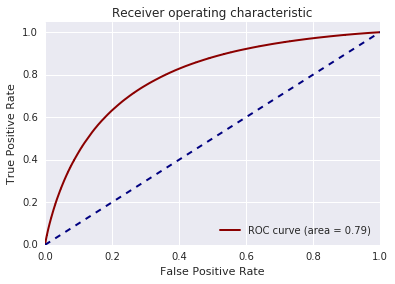

Test ROC AUC: 0.792136895967


In [19]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC AUC
fpr, tpr, thresholds = roc_curve(labelsMod,y_score_mod[:,0])
roc_auc = auc(fpr,tpr)
print "Test ROC AUC:",roc_auc

# Plot ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkred',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
# Save ROC AUC value
f = open("MAndrews_v1_auc.txt","w") 
f.write(str(roc_auc))
f.close()